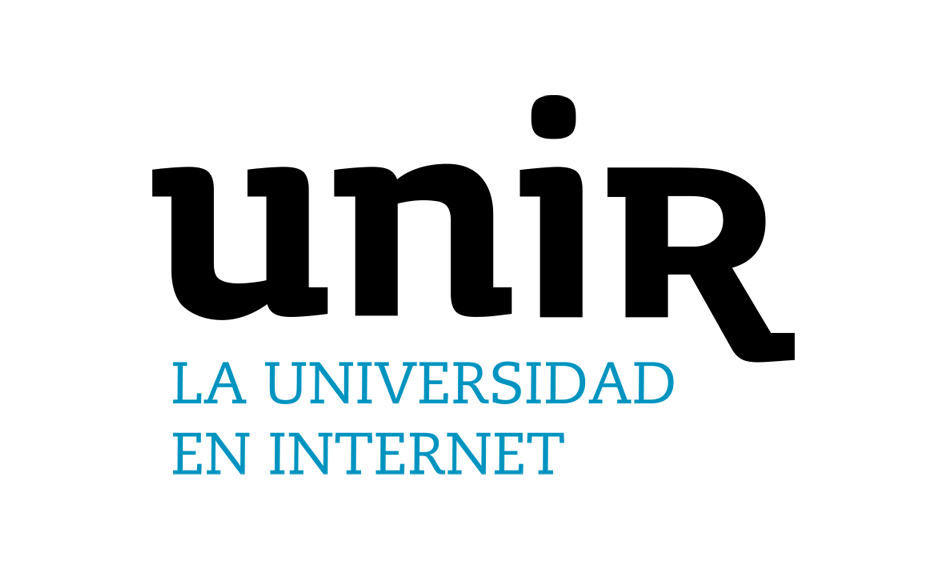
---


# **Máster Universitario en Inteligencia de Negocio**
# Proyecto Transversal

## Importar dataset

In [1]:
import requests
import pandas as pd

url = "https://github.com/anapaccasilva/AdventureWorks/blob/main/DataSet%20SQL%20Analisis%20Masivo%20de%20Datos%20(1).xlsx?raw=true"

response = requests.get(url)

dest = 'local-file.xlsx'

with open(dest, 'wb') as file:
    file.write(response.content)

frame = pd.read_excel(dest, engine='openpyxl')

In [2]:
import pandas as pd
url = "https://github.com/anapaccasilva/AdventureWorks/blob/main/DataSet%20SQL%20Analisis%20Masivo%20de%20Datos%20(1).xlsx?raw=true"

customersPurchases = pd.read_excel(url ,sheet_name="Var Discreta Adq Bicicleta")

# **Modelo de clustering - K-means**

## Preparación de los datos

Crea nuevo dataset con las variables numericas no categoricas

In [69]:
customerPurchases_cluster = customersPurchases[['Age', 'TotalAmount', 'TotalChildren', 'NumberCarsOwned']]

Standardiza las variables

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [71]:
customerPurchases_cluster = scaler.fit_transform(customerPurchases_cluster)


<font face="Biome" size=5 color='#0093C0' > Análisis <font>

---

*El método de agrupamiento k-means no se ajusta bien a variables categóricas, por lo que fueron elegidas unicamente las variables cuantitativas no categoricas para el analisis de cluster. Visto que esas variables están en escalas distintas, fue necesaria la normalización de las mismas.*

## Elbow  Method

Encuentra el numero ideal de clusters

In [72]:
from sklearn.cluster import KMeans

Calcula el WCSS (Intra-Cluster Sum of Square) para k numeros de cluster

In [73]:
distortions = [] #WCSS
K = range(1,11)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(customerPurchases_cluster)
    distortions.append(kmeanModel.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [74]:
import matplotlib.pyplot as plt

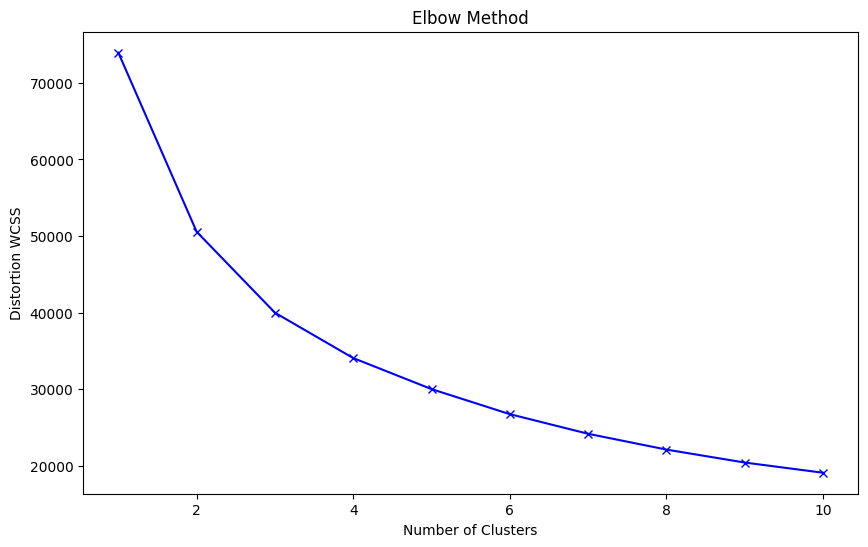

In [75]:
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel("Number of Clusters")
plt.ylabel('Distortion WCSS')
plt.title('Elbow Method')
plt.show()

"Localizador" del codo, o numero ideal de clusters

In [76]:
!pip install kneed
from kneed import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
kl = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")

kl.elbow

3


<font face="Biome" size=5 color='#0093C0' > Análisis <font>

---

*El método de Elbow fue utilizado para encontrar el número ideal de grupos del análisis de cluster. El plot obtenido indica que el “codo” está cerca del numero 4. Sin embargo, dado que el análisis visual puede generar equívocos en algunos casos, fue utilizada la librería “KneeLocator” para confirmar la posición del codo y, por lo tanto, el número optimo de clusters.*

## Clusterización

In [78]:
import numpy as np

In [79]:
kmeansModel = KMeans(n_clusters=3, 
                     init='random', 
                     n_init=10, 
                     max_iter=300, 
                     random_state=123)
y_kmeans = kmeansModel.fit_predict(customerPurchases_cluster)
np.unique(y_kmeans)

array([0, 1, 2], dtype=int32)


<font face="Biome" size=5 color='#0093C0' > Análisis <font>

---

*Fue obtenida el modelo de clusterización con el método K-means, según el número ideal de clusters obtenido anteriormente.*

## PCA

In [80]:
from sklearn.decomposition import PCA

In [81]:
customerPurchases_cluster_pca = customersPurchases[['TotalAmount', 'Age', 'TotalChildren', 'NumberCarsOwned', 'BikePurchase']]

#lista de variables independientes
features = ['TotalAmount', 'Age', 'TotalChildren', 'NumberCarsOwned']

In [82]:
# Separación de las variables independientes
x = customerPurchases_cluster_pca.loc[:, features].values

# Separating de la variable objetivo/dependiente
y = customerPurchases_cluster_pca.loc[:,['BikePurchase']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

Componentes reducidos del modelo PCA

In [83]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

Concatenación de los componentes y la variable target

In [84]:
target_df = customerPurchases_cluster_pca.loc[:,['BikePurchase']]
principalDf.index = target_df.index
finalDf = pd.concat([principalDf, target_df], axis = 1)

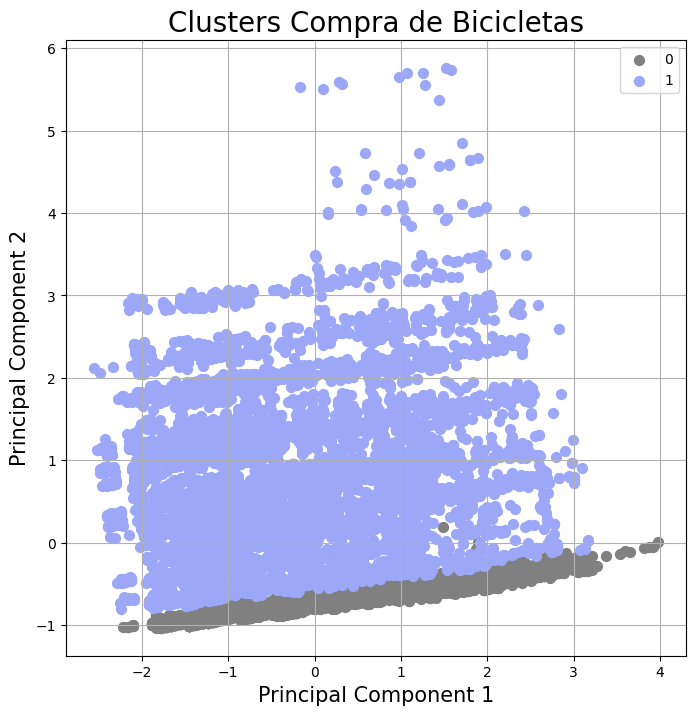

In [85]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Clusters Compra de Bicicletas', fontsize = 20)
targets = [0, 1]

colors = ['#808080', '#9CA8F7']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['BikePurchase'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


<font face="Biome" size=5 color='#0093C0' > Análisis <font>

---

*Con el modelo PCA fue obtenido un modelo de clusterización con dos componentes, que permite visualizar en un plot los grupos de los que compraron o no la bicicleta. Como en el modelo k-means, fueron incorporadas al modelo unicamente las variables no categoricas, excepto por la variable objetivo, obviamente.*